In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader

from utils.dataset import CustomDataset
from model.aotgan import InpaintGenerator

import utils

import torch
import os
import pandas as pd 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import cv2
import numpy as np 


In [3]:
ts_img_dir = '/mnt/HDD/octc/BACKUP/External_ds/data'
ts_mask_dir = '/mnt/HDD/octc/BACKUP/External_ds/mask_filtered'

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

test_dataset = CustomDataset(
    image_dir = ts_img_dir,
    mask_dir = ts_mask_dir,
    transform= test_transform,
    mask_transform= test_transform,
    testing = True,
    mask_shuffle = False,
)
ts_batch = 16

test_loader = DataLoader(dataset = test_dataset, batch_size = ts_batch, shuffle = False)


In [12]:
load_path = '/mnt/HDD/oci_models/aotgan/OCI-GAN_v1_240506/model_79.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
netG = InpaintGenerator().to(device)
G_check = torch.load(load_path)['netG_state_dict']
netG.load_state_dict(G_check)

# G_check를 다시 저장할 때는 아래 코드 사용
torch.save({'netG_state_dict': netG.state_dict()}, '/home/eiden/eiden/capstone/HUFS-BME-AI-WEB/AI/inference/model/weight/OCI-GAN-Generator.pt')

IndexError: list index out of range

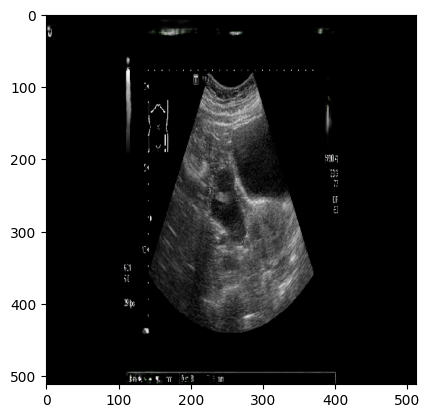

In [14]:
with torch.no_grad():

    netG.eval()
    for images, masks, image_paths in test_loader:
        images, masks = images.to(device), masks.to(device)
        
        masks = masks[:,0:1,:,:]
        ### inference
        pred_images = netG(images,masks)  # 3+1ch
        
        ## mask에서 0이 아닌 부분을 GT로 대체, 이때 마스크는 0~1사이의 값을 가짐 
        comp_images = images.clone()
        comp_images[masks.repeat(1,3,1,1) != 0] = pred_images[masks.repeat(1,3,1,1) != 0] #comp_image를 남겨두는 이유는 result를 확인하기 위함 
        # utils.plotting(images, masks, comp_images)
